In [1]:
"""
=============================================================================
TREINAMENTO TOGETHER COM AUGMENTATION ONLINE AGRESSIVO (80%)
=============================================================================
Pipeline de treinamento com augmentation online forte:
1. Carrega dataset together (já balanceado offline)
2. Aplica augmentation ONLINE agressivo (p=0.8) - 80% das imagens
3. Treina múltiplos modelos: ResNet50, EfficientNet-B0, ViT
4. Early stopping para evitar overfitting
5. Métricas completas para comparação

ESTRATÉGIA:
- Dataset base: together (balanceado offline)
- Augmentation online: MUITO AGRESSIVO (p=0.8) - NÃO salva em disco
- Modelos: 3 arquiteturas diferentes
- Métricas: Completas (Acc, F1, Precision, Recall, por classe)
- Early Stopping: Patience=15

DIFERENCIAL:
- 80% das imagens sofrem transformação A CADA ÉPOCA
- Máxima variabilidade sem explodir armazenamento
- Transformações mais fortes que offline

=============================================================================
"""

import os
import cv2
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time
import psutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# CONFIGURAÇÕES
# =============================================================================

# CONFIGURAÇÕES
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_PATH = r"../data/augmented/TOGETHER"
RESULTS_PATH = r"../results/augmented_online/TOGETHER"
MODELS_PATH = os.path.join(RESULTS_PATH, "models")
METRICS_PATH = os.path.join(RESULTS_PATH, "metrics")
PLOTS_PATH = os.path.join(RESULTS_PATH, "plots")

os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(METRICS_PATH, exist_ok=True)
os.makedirs(PLOTS_PATH, exist_ok=True)

EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 32
NUM_WORKERS = 4
EARLY_STOP_PATIENCE = 15
EARLY_STOP_MIN_DELTA = 0.001
F1_WEIGHT = 0.6
ACC_WEIGHT = 0.4

EMOTION_LABELS = {
    'Raiva': 0, 
    'Nojo': 1, 
    'Medo': 2, 
    'Felicidade': 3,
    'Neutro': 4, 
    'Tristeza': 5, 
    'Surpresa': 6
}

if DEVICE == "cuda":
    torch.cuda.empty_cache()
    gc.collect()
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

print("="*80)
print("TREINAMENTO TOGETHER - DADOS BALANCEADOS")
print("="*80)
print(f"Dispositivo: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Dataset: {DATASET_PATH}")
print("="*80)

TREINAMENTO TOGETHER - DADOS BALANCEADOS
Dispositivo: cuda
GPU: NVIDIA GeForce RTX 2080
Dataset: ../data/augmented/TOGETHER


In [3]:
# CLASSE DE MONITORAMENTO
class ResourceMonitor:
    def __init__(self, model_name):
        self.model_name = model_name
        self.start_time = None
        self.end_time = None
        self.peak_memory_mb = 0
        self.initial_memory_mb = 0
        self.training_time = 0
        self.process = psutil.Process()
        self.peak_gpu_memory_mb = 0
        self.initial_gpu_memory_mb = 0
        
    def start_monitoring(self):
        self.start_time = time.time()
        self.initial_memory_mb = self._get_memory_usage()
        self.peak_memory_mb = self.initial_memory_mb
        
        if torch.cuda.is_available():
            self.initial_gpu_memory_mb = torch.cuda.memory_allocated() / 1024**2
            self.peak_gpu_memory_mb = self.initial_gpu_memory_mb
        
        print(f"\n🔍 Iniciando monitoramento: {self.model_name}")
        print(f"  • Initial RAM: {self.initial_memory_mb:.2f} MB")
        if torch.cuda.is_available():
            print(f"  • Initial GPU: {self.initial_gpu_memory_mb:.2f} MB")
        
    def _get_memory_usage(self):
        return self.process.memory_info().rss / 1024 / 1024
        
    def update_peak_memory(self):
        current_memory = self._get_memory_usage()
        if current_memory > self.peak_memory_mb:
            self.peak_memory_mb = current_memory
        
        if torch.cuda.is_available():
            current_gpu = torch.cuda.max_memory_allocated() / 1024**2
            if current_gpu > self.peak_gpu_memory_mb:
                self.peak_gpu_memory_mb = current_gpu
            
    def end_monitoring(self):
        self.end_time = time.time()
        self.training_time = self.end_time - self.start_time
        final_memory_mb = self._get_memory_usage()
        memory_increase = final_memory_mb - self.initial_memory_mb
        
        print("\n" + "="*70)
        print(f"MONITORING REPORT: {self.model_name.upper()}")
        print("="*70)
        print(f"Total training time: {timedelta(seconds=int(self.training_time))}")
        print(f"Initial RAM: {self.initial_memory_mb:.2f} MB")
        print(f"Final RAM: {final_memory_mb:.2f} MB")
        print(f"Peak RAM: {self.peak_memory_mb:.2f} MB")
        print(f"Memory increase: {memory_increase:.2f} MB")
        
        if torch.cuda.is_available():
            final_gpu = torch.cuda.memory_allocated() / 1024**2
            print(f"Peak GPU Memory: {self.peak_gpu_memory_mb:.2f} MB")
            print(f"Final GPU Memory: {final_gpu:.2f} MB")
        
        print("="*70)
        
        return {
            'training_time_seconds': self.training_time,
            'initial_memory_mb': self.initial_memory_mb,
            'final_memory_mb': final_memory_mb,
            'peak_memory_mb': self.peak_memory_mb,
            'memory_increase_mb': memory_increase,
            'peak_gpu_memory_mb': self.peak_gpu_memory_mb if torch.cuda.is_available() else 0
        }

In [4]:
# EARLY STOPPING
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001, mode='max', verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_score_min = np.inf if mode == 'min' else -np.inf
        
    def __call__(self, val_score):
        if self.mode == 'max':
            score = val_score
        else:
            score = -val_score
            
        if self.best_score is None:
            self.best_score = score
            self.val_score_min = val_score
            if self.verbose:
                print(f'Early Stopping: Baseline: {val_score:.4f}')
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'Early Stopping: Sem melhoria ({self.counter}/{self.patience})')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Early Stopping: ATIVADO após {self.patience} épocas')
        else:
            if self.verbose:
                improvement = val_score - self.val_score_min
                print(f'Early Stopping: Melhoria! ({val_score:.4f}, Δ={improvement:+.4f})')
            self.best_score = score
            self.val_score_min = val_score
            self.counter = 0
            
        return self.early_stop

In [5]:
# AUGMENTATION
def create_train_transform():
    return A.Compose([
        A.OneOf([
            A.HorizontalFlip(p=1.0),
            A.Rotate(limit=20, p=1.0),
            A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=20, p=1.0),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),
            A.GaussNoise(var_limit=(15.0, 50.0), p=1.0),
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
        ], p=0.8),
        A.Resize(height=224, width=224),
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2(),
    ])

def create_val_transform():
    return A.Compose([
        A.Resize(height=224, width=224),
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2(),
    ])

In [6]:
# DATASET
class EmotionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for class_name, class_idx in EMOTION_LABELS.items():
            class_path = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(class_idx)

        if len(self.image_paths) == 0:
            raise ValueError(f"Nenhuma imagem em {root_dir}")

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise ValueError(f"Erro ao carregar: {img_path}")
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, torch.tensor(label, dtype=torch.long)

In [7]:
# MODELOS
def create_model(model_name):
    num_classes = len(EMOTION_LABELS)
    
    try:
        if model_name == 'resnet50':
            model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            
        elif model_name == 'efficientnet_b0':
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
            model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
            model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
            
        elif model_name == 'vit_b_16':
            model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
            model.conv_proj = nn.Conv2d(1, 768, kernel_size=16, stride=16)
            model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
            
        else:
            print(f"❌ Modelo '{model_name}' não suportado")
            return None
        
        print(f"✓ Modelo '{model_name}' criado")
        return model
        
    except Exception as e:
        print(f"❌ Erro ao criar modelo '{model_name}': {e}")
        return None

In [8]:
def create_comprehensive_visualizations(history, conf_matrix, metrics, class_report, 
                                       experiment_id, y_true, y_pred, model_name, 
                                       train_distribution):  # ← NOVO PARÂMETRO
    """
    Visualizações completas com comparação train vs test.
    
    Args:
        train_distribution: dict com contagem de classes do treino
                           formato: {0: count, 1: count, ...}
    """
    fig = plt.figure(figsize=(24, 18))
    emotion_names = list(EMOTION_LABELS.keys())
    
    # 1. ACCURACY
    ax1 = plt.subplot(3, 4, 1)
    epochs = range(1, len(history['val_accuracy']) + 1)
    plt.plot(epochs, [acc * 100 for acc in history['val_accuracy']], 
             'b-', linewidth=2, label='Val Accuracy', marker='o', markersize=3)
    plt.title(f'{model_name.upper()}: Accuracy Evolution', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. LOSS
    ax2 = plt.subplot(3, 4, 2)
    plt.plot(epochs, history['train_loss'], 
             'r-', linewidth=2, label='Train Loss', marker='o', markersize=3)
    plt.title(f'{model_name.upper()}: Loss Evolution', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. MATRIZ RAW
    ax3 = plt.subplot(3, 4, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax3,
                cbar_kws={'label': 'Amostras'})
    plt.title('Matriz de Confusão (Test)', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 4. MATRIZ NORMALIZADA
    ax4 = plt.subplot(3, 4, 4)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.3f', cmap='Greens',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax4,
                cbar_kws={'label': 'Proporção'})
    plt.title('Matriz Normalizada (Recall)', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 5. DISTRIBUIÇÃO TRAIN VS TEST ← MODIFICADO
    ax5 = plt.subplot(3, 4, 5)
    
    # Dados do TESTE
    unique_test, counts_test = np.unique(y_true, return_counts=True)
    test_dist = dict(zip(unique_test, counts_test))
    
    # Organizar dados para plotagem
    train_counts = [train_distribution.get(i, 0) for i in range(len(emotion_names))]
    test_counts = [test_dist.get(i, 0) for i in range(len(emotion_names))]
    
    x = np.arange(len(emotion_names))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, train_counts, width, label='Train (Balanceado)', 
                   alpha=0.8, color='steelblue', edgecolor='black')
    bars2 = plt.bar(x + width/2, test_counts, width, label='Test (Original)', 
                   alpha=0.8, color='coral', edgecolor='black')
    
    plt.title('Distribuição: Train vs Test', fontsize=12, fontweight='bold')
    plt.ylabel('Amostras')
    plt.xlabel('Emoção')
    plt.xticks(x, emotion_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + max(train_counts + test_counts)*0.01,
                    f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # 6. F1-SCORE (Test)
    ax6 = plt.subplot(3, 4, 6)
    f1_scores = [class_report[emotion]['f1-score'] for emotion in emotion_names]
    support_counts = [class_report[emotion]['support'] for emotion in emotion_names]
    bars = plt.bar(emotion_names, f1_scores, color='steelblue', alpha=0.8, edgecolor='black')
    plt.title('F1-Score por Emoção (Test)', fontsize=12, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    for bar, score, support in zip(bars, f1_scores, support_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}\n(n={support})', ha='center', va='bottom', fontsize=9)
    
    # 7. PRECISION, RECALL, F1
    ax7 = plt.subplot(3, 4, 7)
    precision_scores = [class_report[emotion]['precision'] for emotion in emotion_names]
    recall_scores = [class_report[emotion]['recall'] for emotion in emotion_names]
    x = np.arange(len(emotion_names))
    width = 0.25
    bars1 = plt.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='lightcoral')
    bars2 = plt.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='lightblue')
    bars3 = plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='lightgreen')
    plt.title('Métricas por Classe (Test)', fontsize=12, fontweight='bold')
    plt.ylabel('Score')
    plt.xlabel('Emoção')
    plt.xticks(x, emotion_names, rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    
    # 8. F1 MACRO VS WEIGHTED
    ax8 = plt.subplot(3, 4, 8)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    metrics_comparison = {
        'Precision': [precision_macro, precision_weighted],
        'Recall': [recall_macro, recall_weighted],
        'F1-Score': [f1_macro, f1_weighted]
    }
    x = np.arange(len(metrics_comparison))
    width = 0.35
    macro_values = [metrics_comparison[metric][0] for metric in metrics_comparison]
    weighted_values = [metrics_comparison[metric][1] for metric in metrics_comparison]
    bars1 = plt.bar(x - width/2, macro_values, width, label='Macro', alpha=0.8, color='lightcoral')
    bars2 = plt.bar(x + width/2, weighted_values, width, label='Weighted', alpha=0.8, color='lightblue')
    plt.title('Macro vs Weighted (Test)', fontsize=12, fontweight='bold')
    plt.ylabel('Score')
    plt.xlabel('Métrica')
    plt.xticks(x, metrics_comparison.keys())
    plt.legend()
    plt.ylim(0, 1)
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # 9. HEATMAP ERROS
    ax9 = plt.subplot(3, 4, 9)
    error_matrix = conf_matrix.copy()
    np.fill_diagonal(error_matrix, 0)
    error_matrix_norm = error_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    error_matrix_norm = np.nan_to_num(error_matrix_norm)
    sns.heatmap(error_matrix_norm, annot=True, fmt='.3f', cmap='Reds',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax9,
                cbar_kws={'label': 'Proporção de Erros'})
    plt.title('Heatmap de Erros (Test)', fontsize=12, fontweight='bold')
    plt.ylabel('Classe Verdadeira')
    plt.xlabel('Classe Predita')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 10. F1 POR ÉPOCA
    ax10 = plt.subplot(3, 4, 10)
    plt.plot(epochs, history['val_f1_macro'], 'g-', linewidth=2, 
             label='Val F1-Macro', marker='o', markersize=3)
    plt.title('F1-Score Evolution', fontsize=12, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 11. RECURSOS COMPUTACIONAIS
    ax11 = plt.subplot(3, 4, 11)
    resource_data = {
        'Tempo (min)': metrics['training_time_seconds'] / 60,
        'Memória (GB)': metrics['peak_memory_mb'] / 1024,
        'Parâmetros (M)': metrics['total_parameters'] / 1_000_000,
        'Eficiência': metrics['test_accuracy'] / (metrics['total_parameters'] / 1_000_000)
    }
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = plt.bar(range(len(resource_data)), list(resource_data.values()), 
                  color=colors, alpha=0.7, edgecolor='black')
    plt.title(f'Recursos Computacionais\n{model_name.upper()}', fontsize=12, fontweight='bold')
    plt.xticks(range(len(resource_data)), resource_data.keys(), rotation=45)
    plt.ylabel('Valor')
    for bar, (key, value) in zip(bars, resource_data.items()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 12. RESUMO
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    # Calcular diferença de balanceamento
    train_max = max(train_counts)
    train_min = min(train_counts)
    test_max = max(test_counts)
    test_min = min(test_counts)
    train_ratio = train_max / train_min if train_min > 0 else 0
    test_ratio = test_max / test_min if test_min > 0 else 0
    
    summary_text = f"""
{model_name.upper()}
RESUMO

PERFORMANCE (Test):
- Accuracy: {metrics['test_accuracy']:.4f}
- F1-Macro: {f1_macro:.4f}
- F1-Weighted: {f1_weighted:.4f}

DISTRIBUIÇÃO:
- Train Ratio: {train_ratio:.1f}:1
- Test Ratio: {test_ratio:.1f}:1

RECURSOS:
- Parâmetros: {metrics['total_parameters']/1_000_000:.1f}M
- Tempo: {metrics['training_time_seconds']/60:.1f} min
- Memória: {metrics['peak_memory_mb']/1024:.2f} GB

MELHOR/PIOR (Test):
- Melhor: {emotion_names[np.argmax(f1_scores)]} ({max(f1_scores):.3f})
- Pior: {emotion_names[np.argmin(f1_scores)]} ({min(f1_scores):.3f})
    """
    ax12.text(0.05, 0.95, summary_text, fontsize=11, verticalalignment='top',
             transform=ax12.transAxes,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, f'{model_name}_analysis_{experiment_id}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
# TREINAMENTO
def train_epoch(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.cuda.amp.autocast(enabled=(device == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    return running_loss / len(train_loader)

def validate(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.cuda.amp.autocast(enabled=(device == "cuda")):
                outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

def train_model(model_name, train_loader, val_loader, device, epochs, early_stopping, monitor):
    print(f"\n{'='*80}")
    print(f"TREINANDO: {model_name.upper()}")
    print(f"{'='*80}")
    
    monitor.start_monitoring()
    
    model = create_model(model_name)
    if model is None:
        return None
    
    model.to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n📊 Parâmetros: {total_params:,} (Treináveis: {trainable_params:,})")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
    
    history = {
        'train_loss': [], 'val_accuracy': [], 'val_f1_macro': [],
        'val_precision': [], 'val_recall': [], 'combined_metric': []
    }
    
    best_combined_metric = 0.0
    best_val_f1 = 0.0
    best_val_accuracy = 0.0
    best_epoch = 0
    
    for epoch in range(epochs):
        epoch_start = time.time()
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_preds, val_labels = validate(model, val_loader, device)
        
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1_macro = f1_score(val_labels, val_preds, average='macro')
        val_precision = precision_score(val_labels, val_preds, average='macro', zero_division=0)
        val_recall = recall_score(val_labels, val_preds, average='macro', zero_division=0)
        combined_metric = (F1_WEIGHT * val_f1_macro) + (ACC_WEIGHT * val_accuracy)
        
        history['train_loss'].append(train_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1_macro'].append(val_f1_macro)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['combined_metric'].append(combined_metric)
        
        epoch_time = time.time() - epoch_start
        monitor.update_peak_memory()
        
        print(f"\nÉpoca {epoch+1}/{epochs} - {epoch_time:.1f}s")
        print(f"  Loss: {train_loss:.4f} | Acc: {val_accuracy:.4f} | F1: {val_f1_macro:.4f} | Combined: {combined_metric:.4f}")
        
        if combined_metric > best_combined_metric:
            best_combined_metric = combined_metric
            best_val_f1 = val_f1_macro
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            
            model_path = os.path.join(MODELS_PATH, f"{model_name}_best.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': val_f1_macro,
                'val_accuracy': val_accuracy,
                'combined_metric': combined_metric,
            }, model_path)
            print(f"  ✓ Modelo salvo!")
        
        if early_stopping(combined_metric):
            print(f"\nEARLY STOPPING na época {epoch+1}")
            break
    
    monitor_stats = monitor.end_monitoring()
    
    return {
        'model_name': model_name,
        'history': history,
        'best_combined_metric': best_combined_metric,
        'best_val_f1': best_val_f1,
        'best_val_accuracy': best_val_accuracy,
        'best_epoch': best_epoch,
        'epochs_completed': len(history['train_loss']),
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        **monitor_stats
    }

In [10]:
# AVALIAÇÃO
def evaluate_model(model_name, test_loader, device):
    print(f"\n{'='*80}")
    print(f"AVALIAÇÃO: {model_name.upper()}")
    print(f"{'='*80}")
    
    model = create_model(model_name)
    model_path = os.path.join(MODELS_PATH, f"{model_name}_best.pth")
    
    if not os.path.exists(model_path):
        print(f"❌ Modelo não encontrado")
        return None
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    test_preds, test_labels = validate(model, test_loader, device)
    
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1_macro = f1_score(test_labels, test_preds, average='macro')
    test_f1_weighted = f1_score(test_labels, test_preds, average='weighted')
    test_precision = precision_score(test_labels, test_preds, average='macro', zero_division=0)
    test_recall = recall_score(test_labels, test_preds, average='macro', zero_division=0)
    
    class_names = list(EMOTION_LABELS.keys())
    class_report = classification_report(
        test_labels, test_preds,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )
    
    conf_matrix = confusion_matrix(test_labels, test_preds)
    
    print(f"\n📊 MÉTRICAS:")
    print(f"  Accuracy: {test_accuracy:.4f}")
    print(f"  F1-Macro: {test_f1_macro:.4f}")
    print(f"  F1-Weighted: {test_f1_weighted:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")
    
    return {
        'model_name': model_name,
        'test_accuracy': test_accuracy,
        'test_f1_macro': test_f1_macro,
        'test_f1_weighted': test_f1_weighted,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'class_report': class_report,
        'confusion_matrix': conf_matrix.tolist(),
        'y_true': test_labels,
        'y_pred': test_preds,
        'conf_matrix_obj': conf_matrix
    }

In [11]:
def main():
    """Função principal com DOIS testes diferentes: EXPW e RAF-DB."""
    print("\n📂 Carregando datasets...")

    from torch.utils.data import Subset
    from sklearn.model_selection import train_test_split

    train_transform = create_train_transform()
    val_transform = create_val_transform()

    # Carregar treino completo
    train_dataset_full = EmotionDataset(
        root_dir=os.path.join(DATASET_PATH, 'train'),
        transform=train_transform
    )

    # Calcular distribuição do treino
    train_distribution = {}
    for label in train_dataset_full.labels:
        train_distribution[label] = train_distribution.get(label, 0) + 1

    # Split 80/20
    train_indices, val_indices = train_test_split(
        range(len(train_dataset_full)),
        test_size=0.2,
        stratify=train_dataset_full.labels,
        random_state=42
    )

    train_dataset = Subset(train_dataset_full, train_indices)

    val_dataset_full = EmotionDataset(
        root_dir=os.path.join(DATASET_PATH, 'train'),
        transform=val_transform
    )
    val_dataset = Subset(val_dataset_full, val_indices)

    # ===== DOIS DATASETS DE TESTE =====
    # TESTE 1: EXPW
    TEST_1_PATH = r"../data/augmented/EXPW/test"
    test_dataset_1 = EmotionDataset(
        root_dir=TEST_1_PATH,
        transform=val_transform
    )

    # TESTE 2: RAF-DB
    TEST_2_PATH = r"../data/augmented/RAF-DB/test"
    test_dataset_2 = EmotionDataset(
        root_dir=TEST_2_PATH,
        transform=val_transform
    )

    print(f"✓ Train: {len(train_dataset):,} | Val: {len(val_dataset):,}")
    print(f"✓ Test 1 (EXPW): {len(test_dataset_1):,} | Test 2 (RAF-DB): {len(test_dataset_2):,}")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=True)
    test_loader_1 = DataLoader(test_dataset_1, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)
    test_loader_2 = DataLoader(test_dataset_2, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)

    models_to_train = ['resnet50', 'efficientnet_b0', 'vit_b_16']
    all_results = []

    for model_name in models_to_train:
        print(f"\n{'='*80}")
        print(f"MODELO: {model_name.upper()}")
        print(f"{'='*80}")

        # ===== TREINAMENTO (UMA VEZ) =====
        monitor = ResourceMonitor(model_name)
        early_stopping = EarlyStopping(
            patience=EARLY_STOP_PATIENCE,
            min_delta=EARLY_STOP_MIN_DELTA,
            mode='max',
            verbose=True
        )

        train_result = train_model(model_name, train_loader, val_loader, DEVICE,
                                  EPOCHS, early_stopping, monitor)

        if train_result:
            # ===== TESTE 1: EXPW =====
            print(f"\n{'='*80}")
            print(f"TESTE 1: EXPW ({TEST_1_PATH})")
            print(f"{'='*80}")
            eval_result_1 = evaluate_model(model_name, test_loader_1, DEVICE)

            # ===== TESTE 2: RAF-DB =====
            print(f"\n{'='*80}")
            print(f"TESTE 2: RAF-DB ({TEST_2_PATH})")
            print(f"{'='*80}")
            eval_result_2 = evaluate_model(model_name, test_loader_2, DEVICE)

            if eval_result_1 and eval_result_2:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

                # ===== SALVAR RESULTADOS TESTE 1 (EXPW) =====
                combined_result_1 = {**train_result, **eval_result_1}
                combined_result_1['test_name'] = 'EXPW'
                all_results.append(combined_result_1)

                metrics_for_viz_1 = {
                    'test_accuracy': eval_result_1['test_accuracy'],
                    'training_time_seconds': train_result['training_time_seconds'],
                    'peak_memory_mb': train_result['peak_memory_mb'],
                    'total_parameters': train_result['total_parameters']
                }

                create_comprehensive_visualizations(
                    history=train_result['history'],
                    conf_matrix=eval_result_1['conf_matrix_obj'],
                    metrics=metrics_for_viz_1,
                    class_report=eval_result_1['class_report'],
                    experiment_id=f"{model_name}_EXPW_{timestamp}",
                    y_true=eval_result_1['y_true'],
                    y_pred=eval_result_1['y_pred'],
                    model_name=f"{model_name} (EXPW)",
                    train_distribution=train_distribution
                )

                metrics_df_1 = pd.DataFrame([combined_result_1])
                metrics_df_1.to_csv(
                    os.path.join(METRICS_PATH, f'metrics_{model_name}_EXPW_{timestamp}.csv'),
                    index=False
                )

                # ===== SALVAR RESULTADOS TESTE 2 (RAF-DB) =====
                combined_result_2 = {**train_result, **eval_result_2}
                combined_result_2['test_name'] = 'RAF-DB'
                all_results.append(combined_result_2)

                metrics_for_viz_2 = {
                    'test_accuracy': eval_result_2['test_accuracy'],
                    'training_time_seconds': train_result['training_time_seconds'],
                    'peak_memory_mb': train_result['peak_memory_mb'],
                    'total_parameters': train_result['total_parameters']
                }

                create_comprehensive_visualizations(
                    history=train_result['history'],
                    conf_matrix=eval_result_2['conf_matrix_obj'],
                    metrics=metrics_for_viz_2,
                    class_report=eval_result_2['class_report'],
                    experiment_id=f"{model_name}_RAFDB_{timestamp}",
                    y_true=eval_result_2['y_true'],
                    y_pred=eval_result_2['y_pred'],
                    model_name=f"{model_name} (RAF-DB)",
                    train_distribution=train_distribution
                )

                metrics_df_2 = pd.DataFrame([combined_result_2])
                metrics_df_2.to_csv(
                    os.path.join(METRICS_PATH, f'metrics_{model_name}_RAFDB_{timestamp}.csv'),
                    index=False
                )

                # ===== COMPARAÇÃO EXPW vs RAF-DB =====
                print(f"\n{'='*80}")
                print(f"COMPARAÇÃO: {model_name.upper()} - EXPW vs RAF-DB")
                print(f"{'='*80}")
                print(f"{'Métrica':<20} {'EXPW':>12} {'RAF-DB':>12} {'Diferença':>12}")
                print(f"{'-'*60}")
                print(f"{'Accuracy':<20} {eval_result_1['test_accuracy']:>12.4f} {eval_result_2['test_accuracy']:>12.4f} {eval_result_2['test_accuracy']-eval_result_1['test_accuracy']:>+12.4f}")
                print(f"{'F1-Macro':<20} {eval_result_1['test_f1_macro']:>12.4f} {eval_result_2['test_f1_macro']:>12.4f} {eval_result_2['test_f1_macro']-eval_result_1['test_f1_macro']:>+12.4f}")
                print(f"{'F1-Weighted':<20} {eval_result_1['test_f1_weighted']:>12.4f} {eval_result_2['test_f1_weighted']:>12.4f} {eval_result_2['test_f1_weighted']-eval_result_1['test_f1_weighted']:>+12.4f}")
                print(f"{'Precision':<20} {eval_result_1['test_precision']:>12.4f} {eval_result_2['test_precision']:>12.4f} {eval_result_2['test_precision']-eval_result_1['test_precision']:>+12.4f}")
                print(f"{'Recall':<20} {eval_result_1['test_recall']:>12.4f} {eval_result_2['test_recall']:>12.4f} {eval_result_2['test_recall']-eval_result_1['test_recall']:>+12.4f}")
                print(f"{'='*80}")

        if DEVICE == "cuda":
            torch.cuda.empty_cache()
            gc.collect()

    if all_results:
        comparison_df = pd.DataFrame(all_results)
        comparison_df.to_csv(
            os.path.join(METRICS_PATH, 'comparison_all_models_EXPW_RAFDB.csv'),
            index=False
        )

        print(f"\n{'='*80}")
        print("COMPARAÇÃO FINAL - TODOS OS MODELOS (EXPW vs RAF-DB)")
        print(f"{'='*80}")
        print(comparison_df[['model_name', 'test_name', 'test_accuracy', 'test_f1_macro',
                             'best_epoch', 'epochs_completed', 'training_time_seconds',
                             'peak_memory_mb']].to_string(index=False))
        print(f"{'='*80}")

    print(f"\n✅ Completo!")
    print(f"📁 {RESULTS_PATH}")


📂 Carregando datasets...
✓ Train: 164,083 | Val: 41,021
✓ Test 1 (EXPW): 17,102 | Test 2 (RAF-DB): 3,068

MODELO: RESNET50

TREINANDO: RESNET50

🔍 Iniciando monitoramento: resnet50
  • Initial RAM: 833.57 MB
  • Initial GPU: 0.00 MB
✓ Modelo 'resnet50' criado

📊 Parâmetros: 23,516,103 (Treináveis: 23,516,103)

Época 1/100 - 466.7s
  Loss: 1.4800 | Acc: 0.5779 | F1: 0.5704 | Combined: 0.5734
  ✓ Modelo salvo!
Early Stopping: Baseline: 0.5734

Época 2/100 - 474.9s
  Loss: 1.0991 | Acc: 0.6919 | F1: 0.6922 | Combined: 0.6921
  ✓ Modelo salvo!
Early Stopping: Melhoria! (0.6921, Δ=+0.1187)

Época 3/100 - 475.2s
  Loss: 0.8952 | Acc: 0.7519 | F1: 0.7495 | Combined: 0.7504
  ✓ Modelo salvo!
Early Stopping: Melhoria! (0.7504, Δ=+0.0584)

Época 4/100 - 475.0s
  Loss: 0.7691 | Acc: 0.7868 | F1: 0.7851 | Combined: 0.7858
  ✓ Modelo salvo!
Early Stopping: Melhoria! (0.7858, Δ=+0.0354)

Época 5/100 - 469.3s
  Loss: 0.6847 | Acc: 0.8017 | F1: 0.7990 | Combined: 0.8001
  ✓ Modelo salvo!
Early Stoppi

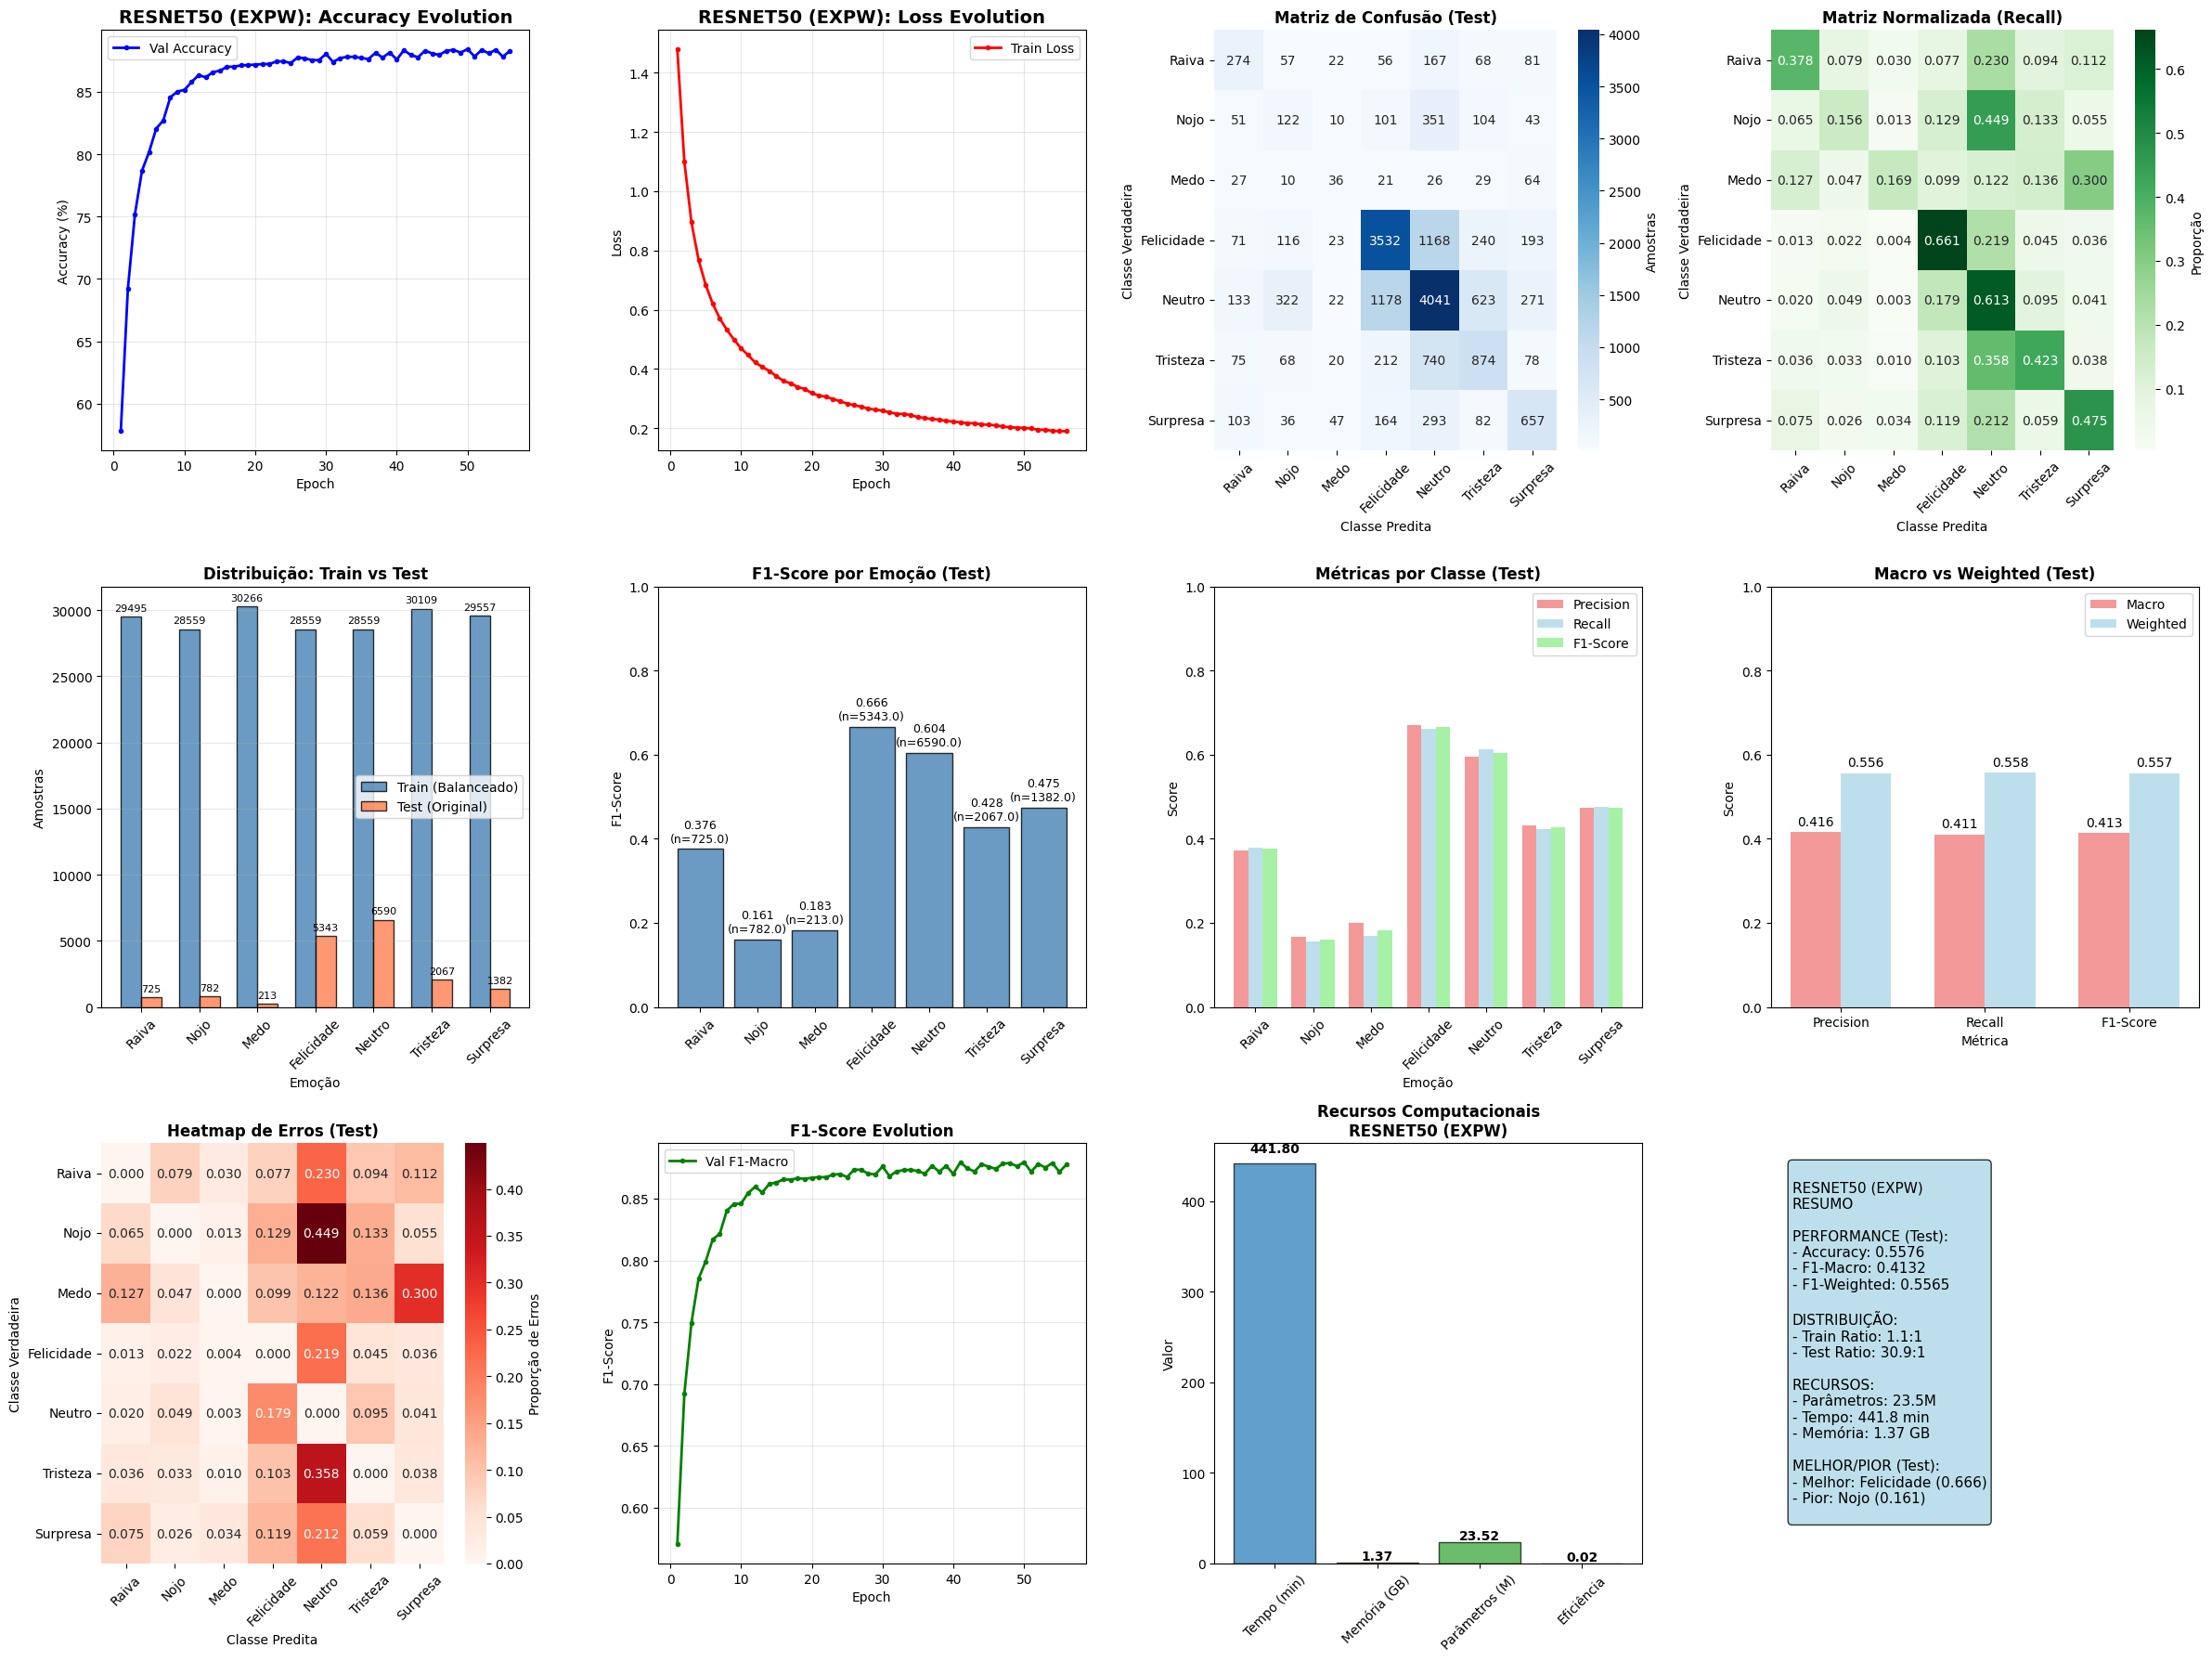

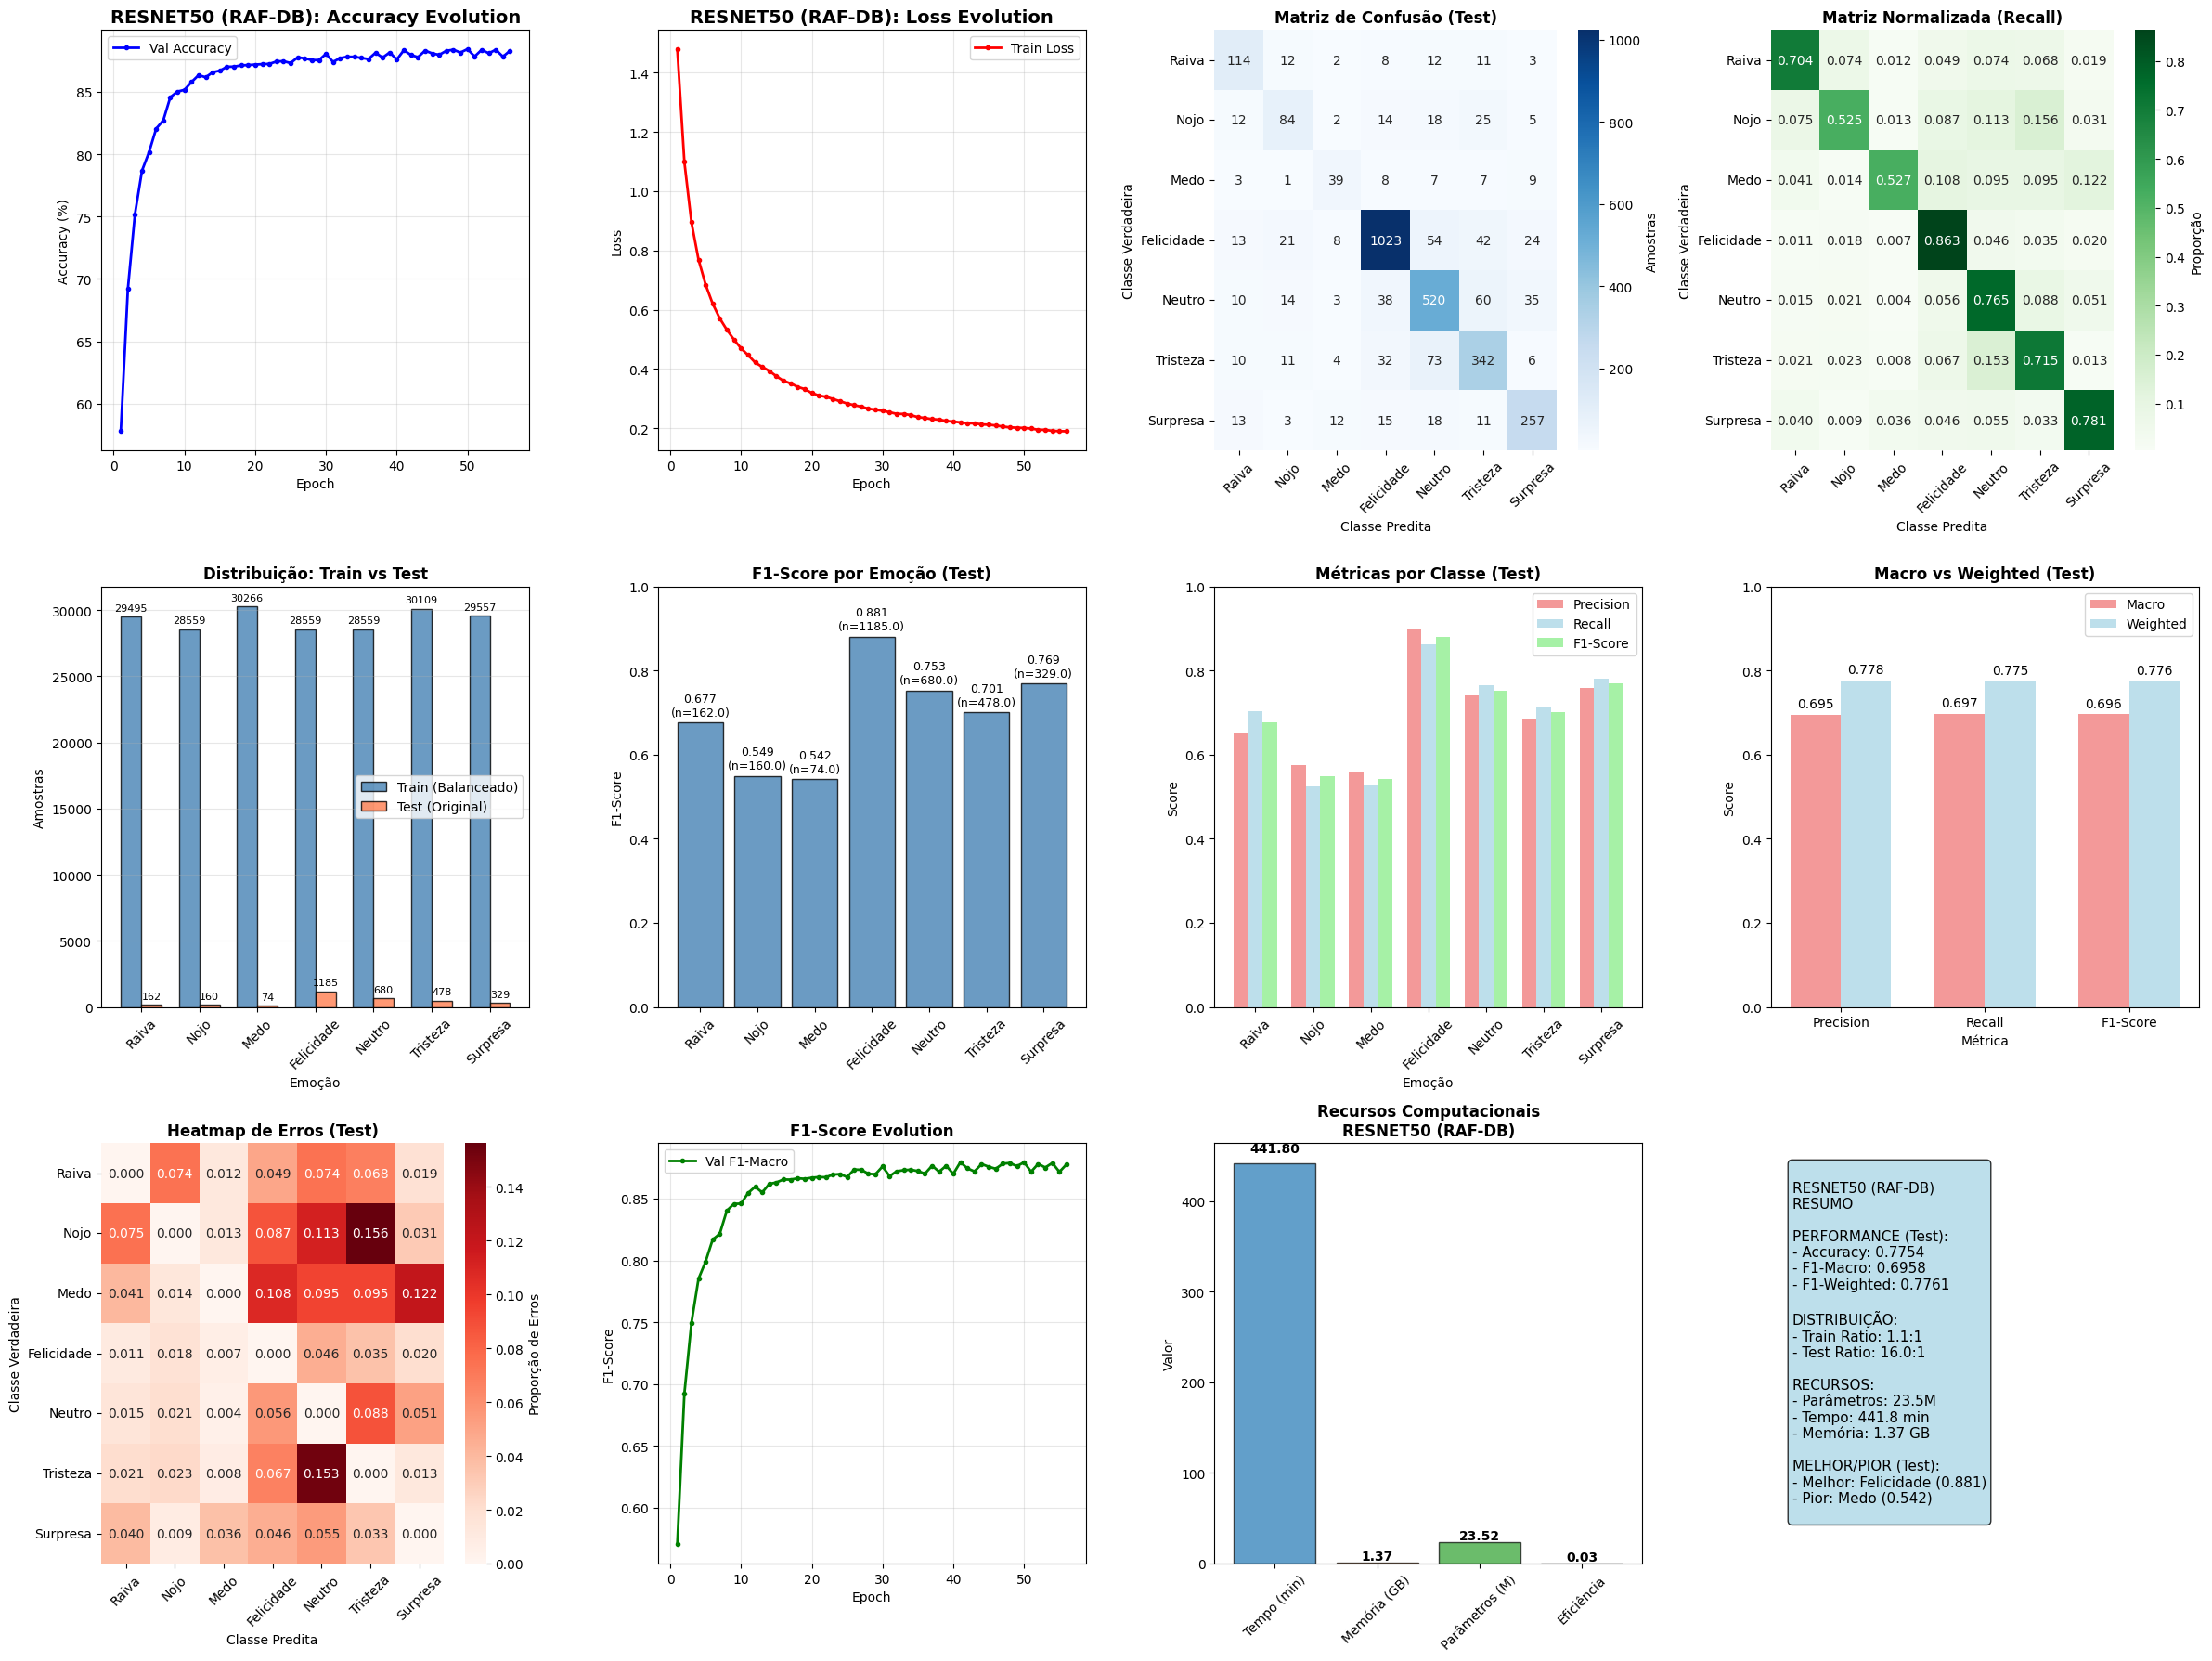


COMPARAÇÃO: RESNET50 - EXPW vs RAF-DB
Métrica                      EXPW       RAF-DB    Diferença
------------------------------------------------------------
Accuracy                   0.5576       0.7754      +0.2178
F1-Macro                   0.4132       0.6958      +0.2826
F1-Weighted                0.5565       0.7761      +0.2196
Precision                  0.4161       0.6955      +0.2793
Recall                     0.4108       0.6972      +0.2864

MODELO: EFFICIENTNET_B0

TREINANDO: EFFICIENTNET_B0

🔍 Iniciando monitoramento: efficientnet_b0
  • Initial RAM: 1506.80 MB
  • Initial GPU: 16.25 MB
✓ Modelo 'efficientnet_b0' criado

📊 Parâmetros: 4,015,939 (Treináveis: 4,015,939)

Época 1/100 - 281.6s
  Loss: 1.5147 | Acc: 0.5916 | F1: 0.5853 | Combined: 0.5878
  ✓ Modelo salvo!
Early Stopping: Baseline: 0.5878

Época 2/100 - 281.8s
  Loss: 1.1940 | Acc: 0.6721 | F1: 0.6678 | Combined: 0.6695
  ✓ Modelo salvo!
Early Stopping: Melhoria! (0.6695, Δ=+0.0817)

Época 3/100 - 281.1s
  L

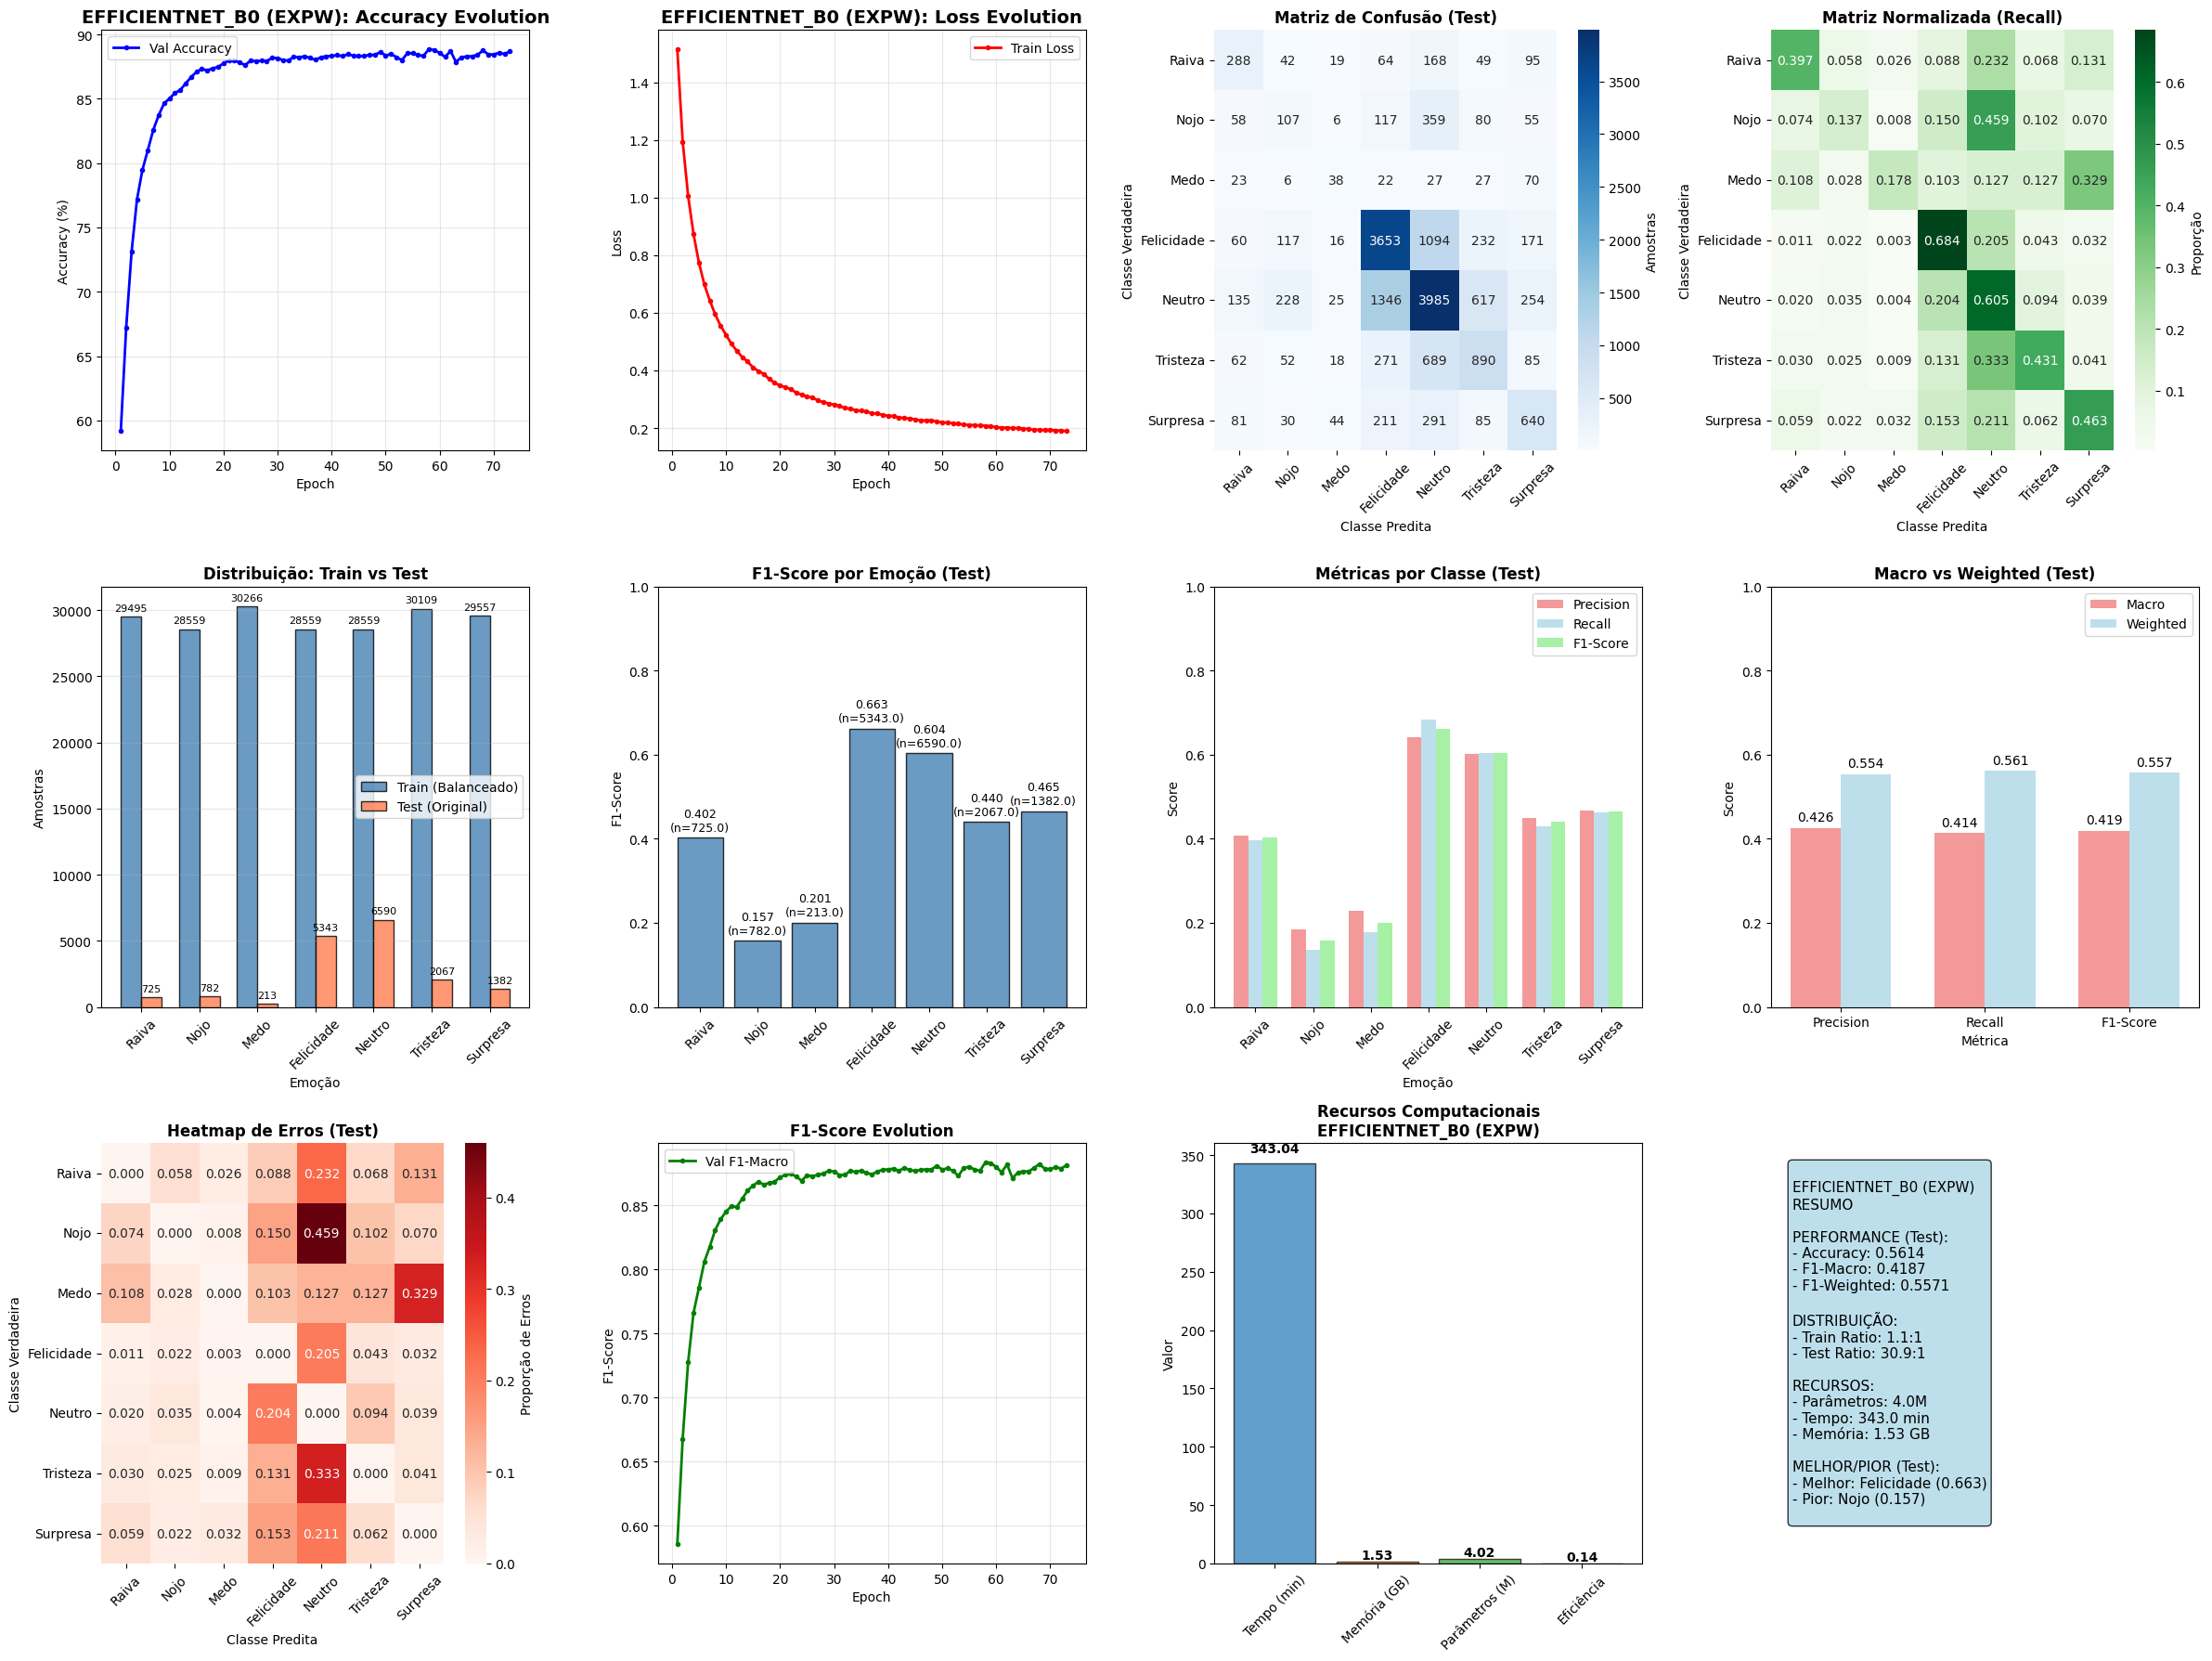

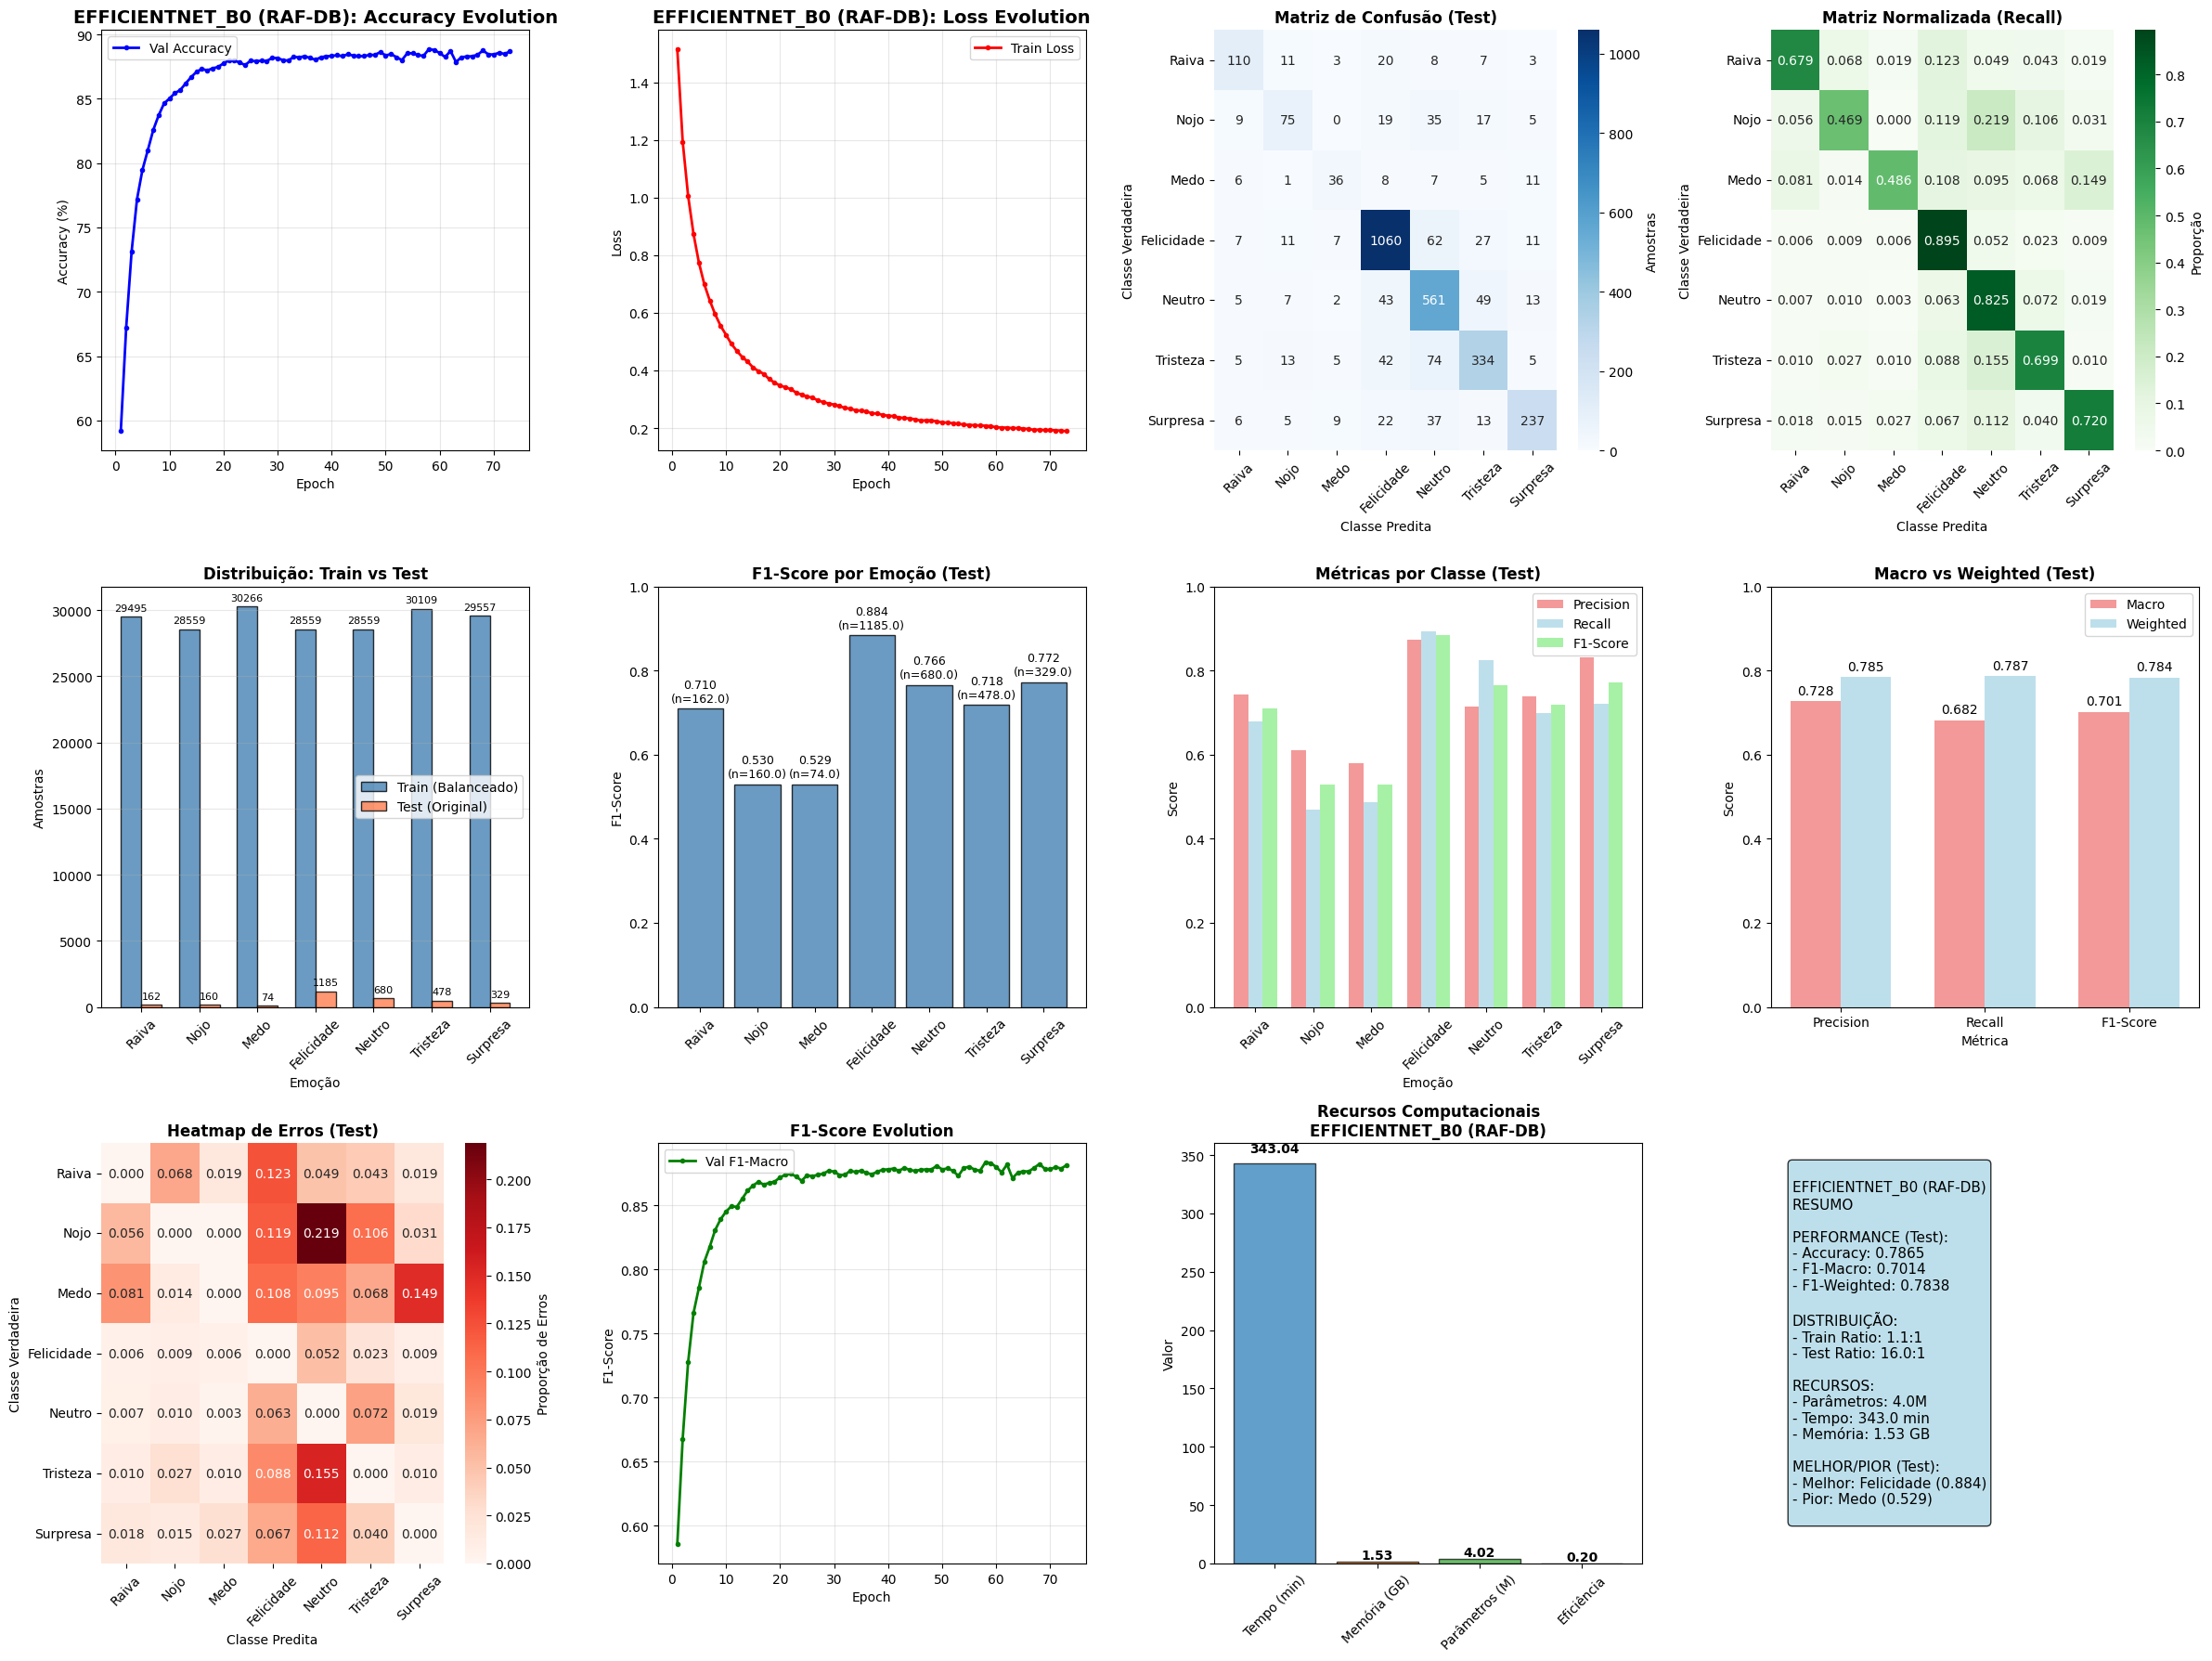


COMPARAÇÃO: EFFICIENTNET_B0 - EXPW vs RAF-DB
Métrica                      EXPW       RAF-DB    Diferença
------------------------------------------------------------
Accuracy                   0.5614       0.7865      +0.2251
F1-Macro                   0.4187       0.7014      +0.2827
F1-Weighted                0.5571       0.7838      +0.2267
Precision                  0.4260       0.7276      +0.3015
Recall                     0.4135       0.6818      +0.2683

MODELO: VIT_B_16

TREINANDO: VIT_B_16

🔍 Iniciando monitoramento: vit_b_16
  • Initial RAM: 1551.17 MB
  • Initial GPU: 16.25 MB
✓ Modelo 'vit_b_16' criado

📊 Parâmetros: 85,410,823 (Treináveis: 85,410,823)

Época 1/100 - 1100.3s
  Loss: 1.8987 | Acc: 0.2834 | F1: 0.2778 | Combined: 0.2801
  ✓ Modelo salvo!
Early Stopping: Baseline: 0.2801

Época 2/100 - 1104.5s
  Loss: 1.7129 | Acc: 0.3985 | F1: 0.3858 | Combined: 0.3908
  ✓ Modelo salvo!
Early Stopping: Melhoria! (0.3908, Δ=+0.1108)

Época 3/100 - 1136.7s
  Loss: 1.5450 | Ac

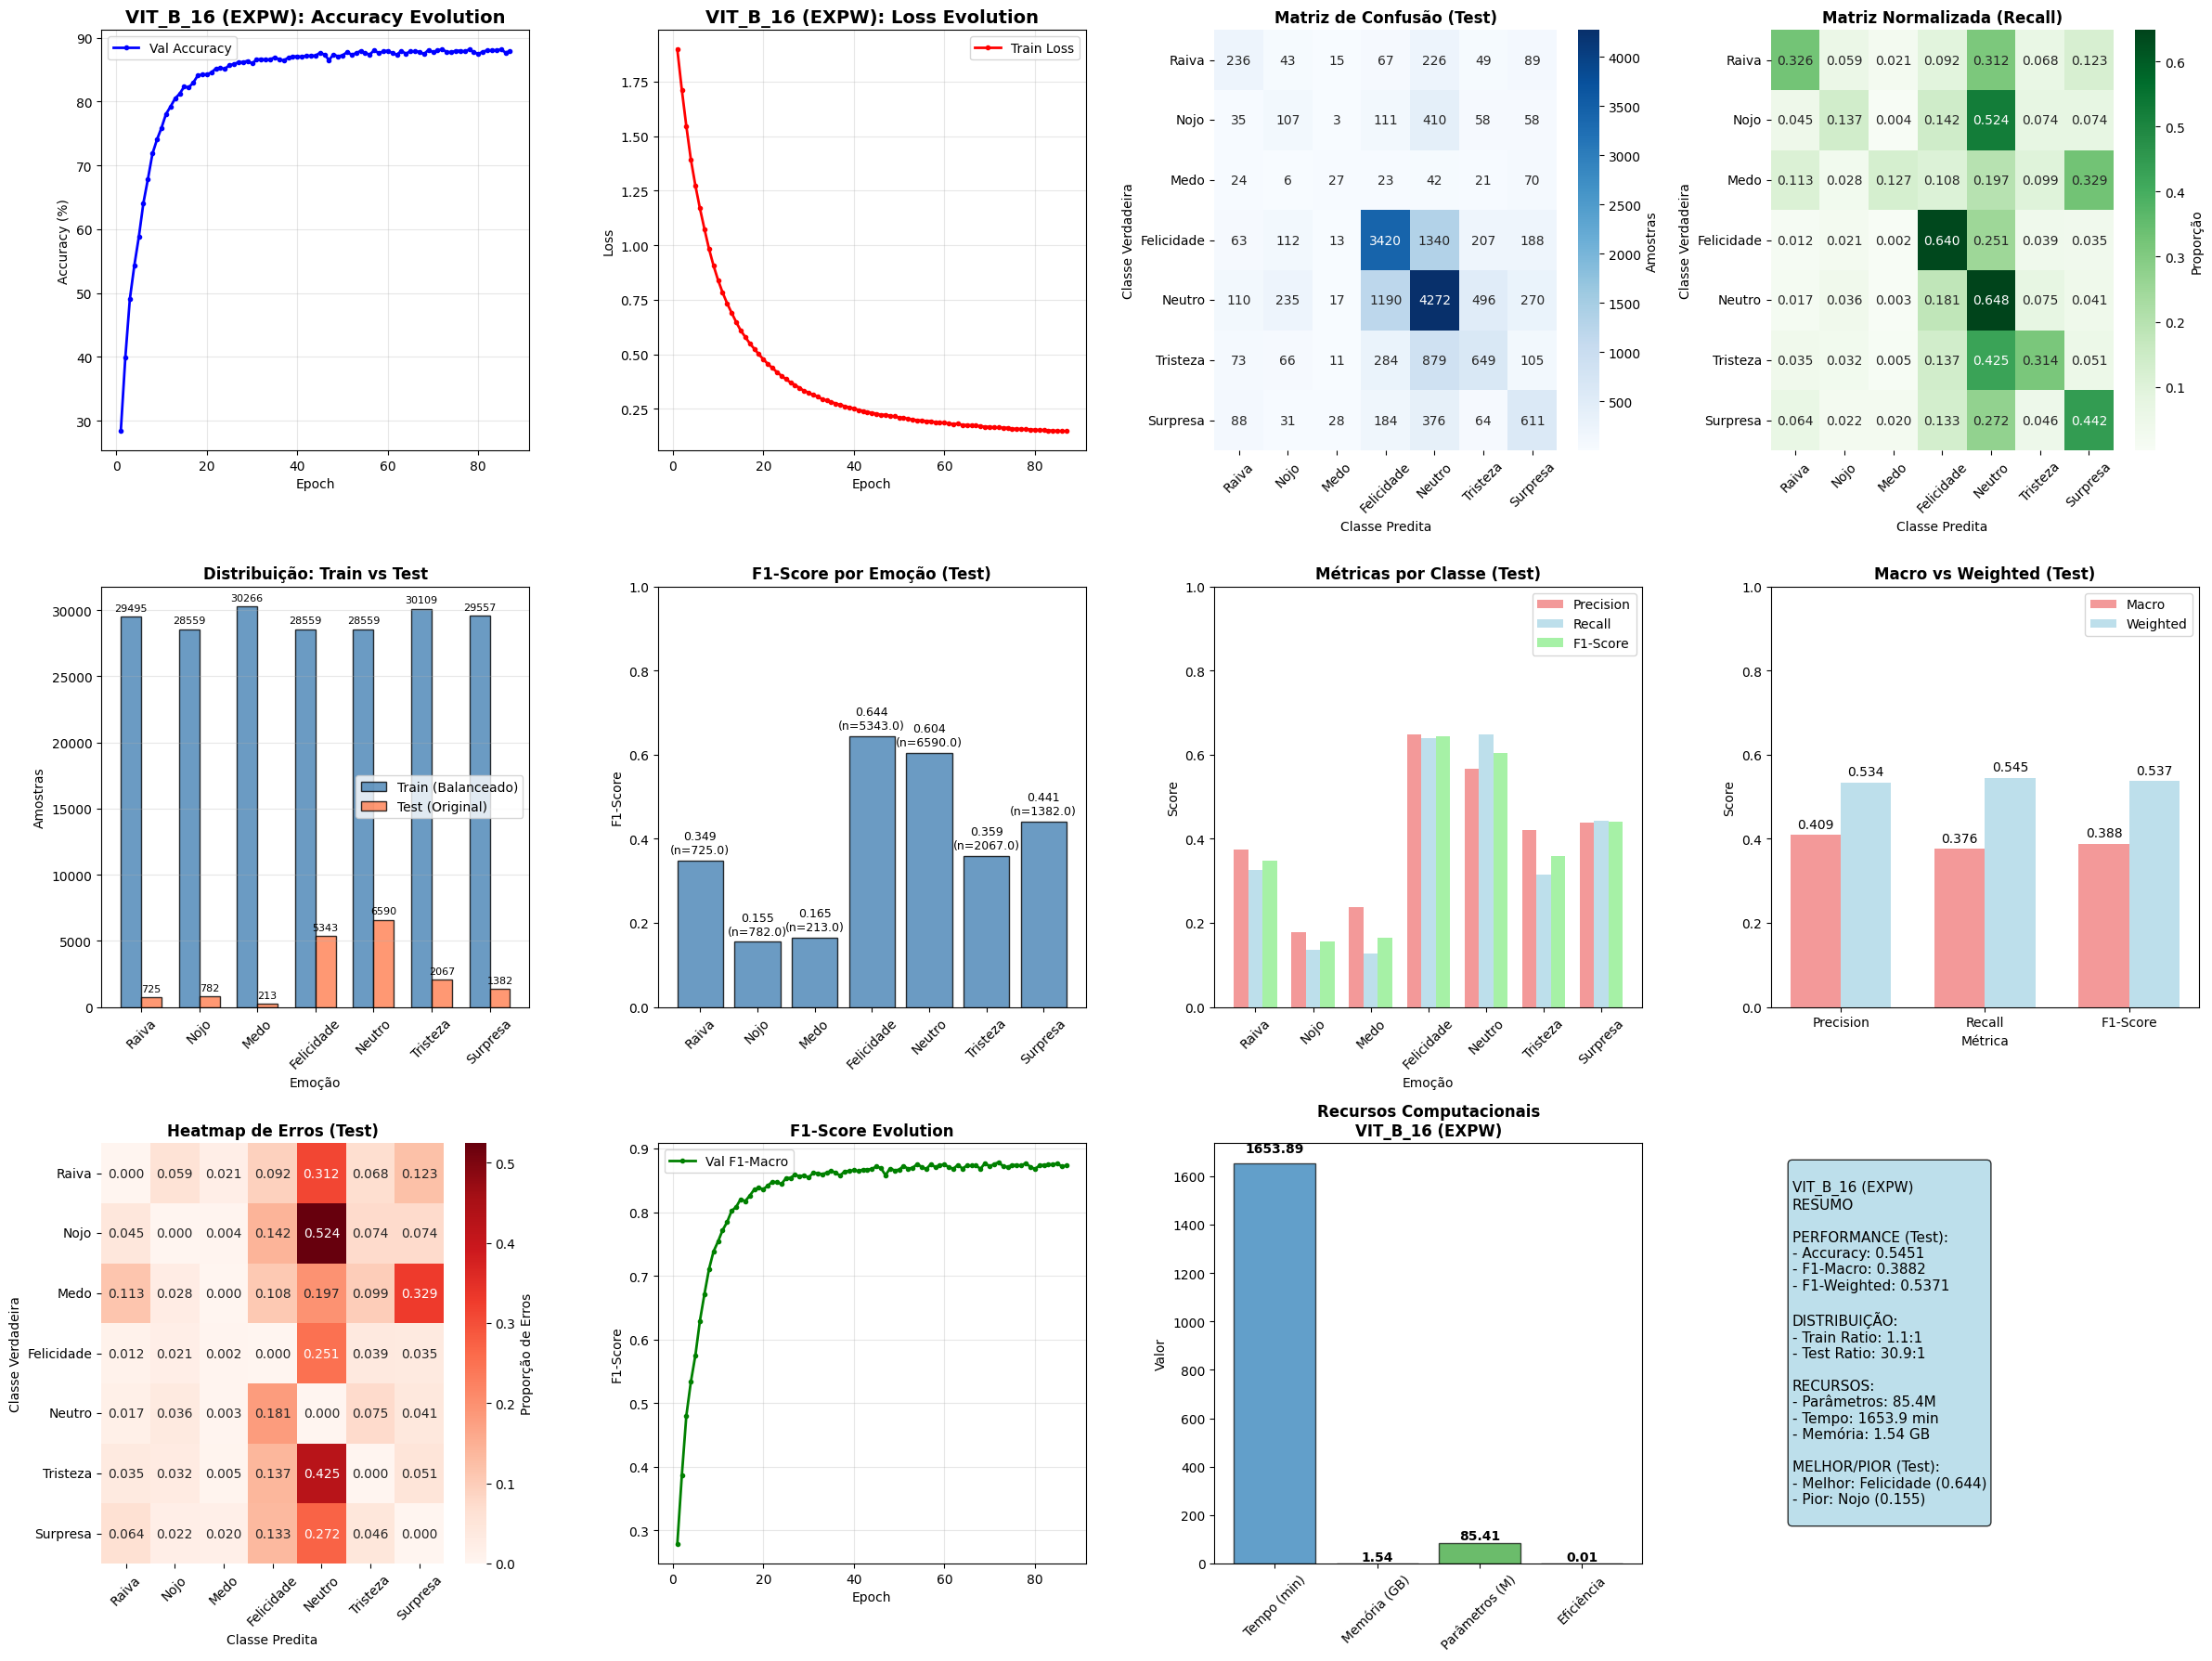

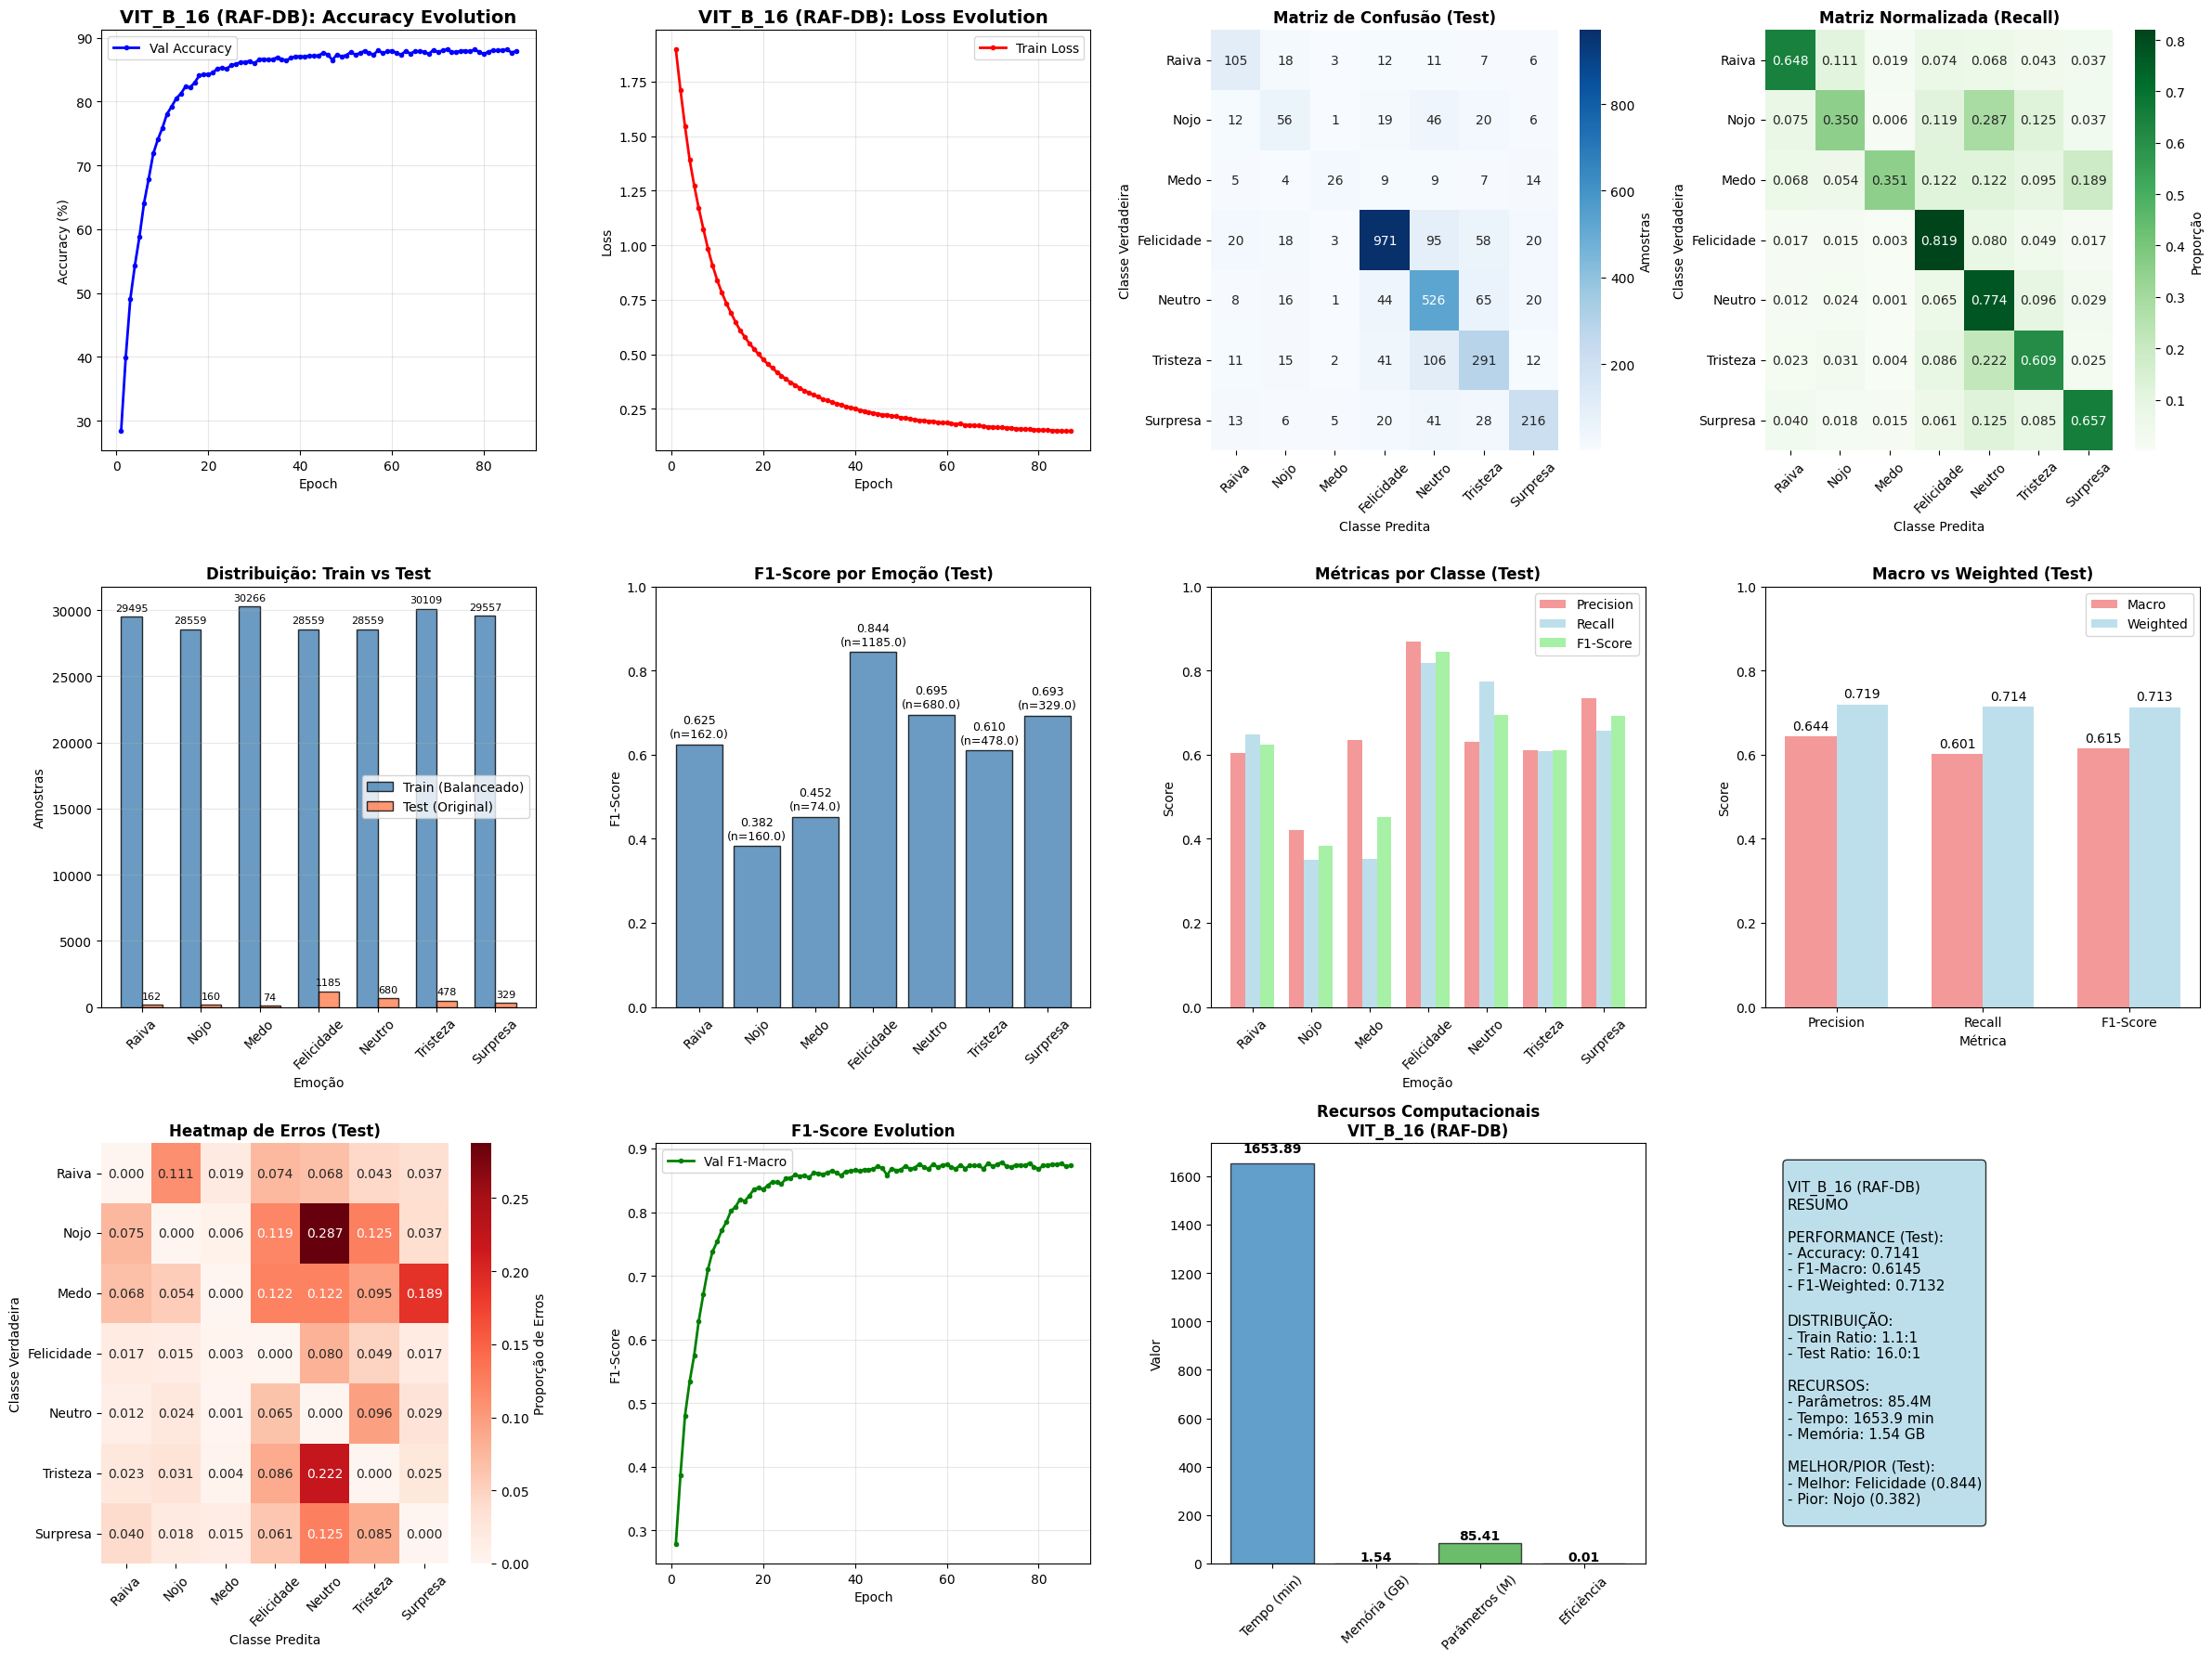


COMPARAÇÃO: VIT_B_16 - EXPW vs RAF-DB
Métrica                      EXPW       RAF-DB    Diferença
------------------------------------------------------------
Accuracy                   0.5451       0.7141      +0.1691
F1-Macro                   0.3882       0.6145      +0.2264
F1-Weighted                0.5371       0.7132      +0.1762
Precision                  0.4091       0.6436      +0.2345
Recall                     0.3762       0.6011      +0.2249

COMPARAÇÃO FINAL - TODOS OS MODELOS (EXPW vs RAF-DB)
     model_name test_name  test_accuracy  test_f1_macro  best_epoch  epochs_completed  training_time_seconds  peak_memory_mb
       resnet50      EXPW       0.557596       0.413215          50                56           26508.275233     1404.925781
       resnet50    RAF-DB       0.775424       0.695831          50                56           26508.275233     1404.925781
efficientnet_b0      EXPW       0.561396       0.418687          58                73           20582.608937   

In [12]:
if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\n\n⚠️ Interrompido")
    except Exception as e:
        print(f"\n\n❌ ERRO: {type(e).__name__}")
        print(f"{e}")
        import traceback
        traceback.print_exc()